In [1]:
import pandas as pd
import numpy as np
import glob
import os

file_paths = sorted(glob.glob('papaya_data/*.csv'))
all_data = []

for file in file_paths:
    df = pd.read_csv(file)
    if 'Back' in df.iloc[:, -1].unique():
        df = df[df.iloc[:, -1] != 'Back']
    all_data.append(df)

data_all = pd.concat(all_data, axis=0).reset_index(drop=True)
print(f"전체 시점 수: {len(data_all)}")


전체 시점 수: 10685


In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 🔹 방향각의 변화량 (delta azimuth) 추가
azimuth_rad = np.radians(data_all['azimuth'])
delta_azimuth = np.diff(azimuth_rad, prepend=azimuth_rad.iloc[0])
delta_azimuth = (delta_azimuth + np.pi) % (2 * np.pi) - np.pi  # [-π, π] 범위로 정규화
data_all['dAzimuth'] = delta_azimuth

# 🔹 sin, cos 변환
data_all['azimuth_sin'] = np.sin(azimuth_rad)
data_all['azimuth_cos'] = np.cos(azimuth_rad)

# 🔹 가속도 변화량
for axis in ['X', 'Y', 'Z']:
    col = f'accel{axis}'
    dcol = f'dAccel{axis}'
    data_all[dcol] = data_all[col].diff().fillna(0)

# 🔹 정규화 대상 선정
exclude_cols = ['timestamp', 'timestamp_offset', 'direction', 'azimuth']
feature_cols = [col for col in data_all.columns if col not in exclude_cols]

# 🔹 정규화
scaler = StandardScaler()
data_all[feature_cols] = scaler.fit_transform(data_all[feature_cols])

# 🔹 사용하지 않는 열 제거
data_all = data_all.drop(columns=['timestamp', 'timestamp_offset', 'azimuth'])


In [3]:
from collections import Counter

def generate_sliding_windows(df, window_size=5):
    X_all, y_all = [], []
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i+window_size]
        features = window.iloc[:, :-1].values.astype(np.float32)
        label = window.iloc[:, -1].mode()[0]
        X_all.append(features)
        y_all.append(label)
    return np.array(X_all), np.array(y_all)

# 라벨을 direction 그대로 사용
X_all, y_all = generate_sliding_windows(data_all[feature_cols + ['direction']])
print(f"입력 shape: {X_all.shape}, 라벨 분포: {Counter(y_all)}")


입력 shape: (10681, 5, 18), 라벨 분포: Counter({'Front': 7704, 'Stay': 1069, 'Right': 1041, 'Left': 867})


In [4]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
folds = list(skf.split(X_all, y_all))


In [5]:
import torch
import torch.nn as nn

class CNN_GRU_Classifier(nn.Module):
    def __init__(self, seq_len=5, feature_dim=13):
        super().__init__()
        self.conv1 = nn.Conv1d(feature_dim, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(32, 32, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(32 * 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, C, L)
        x = self.relu(self.bn1(self.conv1(x)))
        x = x.permute(0, 2, 1)  # (B, L, C)
        _, h_n = self.gru(x)
        h = torch.cat([h_n[0], h_n[1]], dim=1)
        x = self.relu(self.fc1(h))
        return self.fc2(x)


In [6]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [7]:
from torch.utils.data import TensorDataset, DataLoader

def train_binary_model(X_train, y_train, X_val, y_val, feature_dim):
    model = CNN_GRU_Classifier(seq_len=X_train.shape[1], feature_dim=feature_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=10)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb), yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        if early_stopping(val_loss, model):
            break

    model.load_state_dict(early_stopping.best_model)
    return model


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

all_labels = ['Stay', 'Front', 'Left', 'Right']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
total_cm = np.zeros((4, 4), dtype=int)
total_y_true = []
total_y_pred = []

def train_binary_model(X_train_np, y_train_np, X_val_np, y_val_np, feature_dim, label_name=''):
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_val = torch.tensor(X_val_np, dtype=torch.float32)
    y_val = torch.tensor(y_val_np, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

    model = CNN_GRU_Classifier(seq_len=X_train.shape[1], feature_dim=feature_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=10)

    train_losses, val_losses = [], []

    for epoch in range(100):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        train_losses.append(epoch_loss / len(train_loader.dataset))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb), yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"{label_name} | Epoch {epoch:03d} | Train: {train_losses[-1]:.4f} | Val: {val_loss:.4f}")
        if early_stopping(val_loss, model):
            print(f"{label_name} Early Stopping at epoch {epoch}")
            break

    model.load_state_dict(early_stopping.best_model)

    # ✅ loss curve
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.axvline(len(val_losses) - early_stopping.counter - 1, color='red', linestyle='--', label='Best Epoch')
    plt.title(f"{label_name} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    return model



=== Fold 0 ===
Fold 0 - Stay vs Move | Epoch 000 | Train: 0.2979 | Val: 0.1821
Fold 0 - Stay vs Move | Epoch 001 | Train: 0.1420 | Val: 0.1293
Fold 0 - Stay vs Move | Epoch 002 | Train: 0.1160 | Val: 0.1068
Fold 0 - Stay vs Move | Epoch 003 | Train: 0.1057 | Val: 0.1065
Fold 0 - Stay vs Move | Epoch 004 | Train: 0.0972 | Val: 0.0968
Fold 0 - Stay vs Move | Epoch 005 | Train: 0.0900 | Val: 0.0944
Fold 0 - Stay vs Move | Epoch 006 | Train: 0.0833 | Val: 0.0878
Fold 0 - Stay vs Move | Epoch 007 | Train: 0.0766 | Val: 0.1020
Fold 0 - Stay vs Move | Epoch 008 | Train: 0.0740 | Val: 0.0831
Fold 0 - Stay vs Move | Epoch 009 | Train: 0.0677 | Val: 0.0750
Fold 0 - Stay vs Move | Epoch 010 | Train: 0.0632 | Val: 0.0648
Fold 0 - Stay vs Move | Epoch 011 | Train: 0.0631 | Val: 0.0699
Fold 0 - Stay vs Move | Epoch 012 | Train: 0.0607 | Val: 0.0739
Fold 0 - Stay vs Move | Epoch 013 | Train: 0.0527 | Val: 0.0642
Fold 0 - Stay vs Move | Epoch 014 | Train: 0.0489 | Val: 0.0724
Fold 0 - Stay vs Move | 

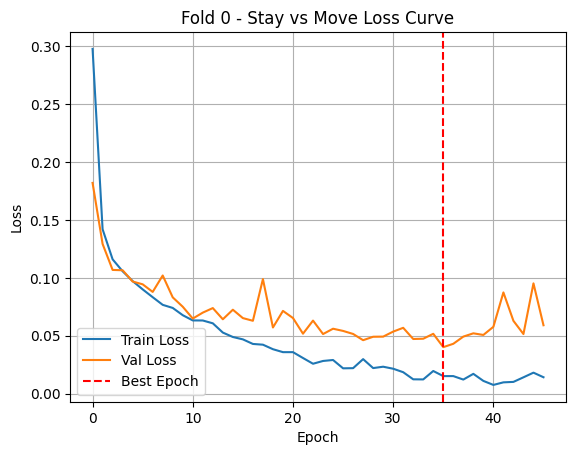

Confusion Matrix - Stay vs Move


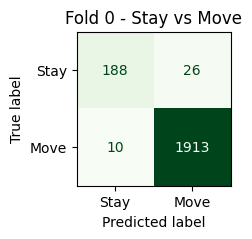

              precision    recall  f1-score   support

        Stay     0.9495    0.8785    0.9126       214
        Move     0.9866    0.9948    0.9907      1923

    accuracy                         0.9832      2137
   macro avg     0.9680    0.9367    0.9516      2137
weighted avg     0.9829    0.9832    0.9829      2137

Fold 0 - Front vs Turn | Epoch 000 | Train: 0.4020 | Val: 0.2589
Fold 0 - Front vs Turn | Epoch 001 | Train: 0.2509 | Val: 0.2337
Fold 0 - Front vs Turn | Epoch 002 | Train: 0.2318 | Val: 0.2171
Fold 0 - Front vs Turn | Epoch 003 | Train: 0.2153 | Val: 0.2080
Fold 0 - Front vs Turn | Epoch 004 | Train: 0.2019 | Val: 0.2086
Fold 0 - Front vs Turn | Epoch 005 | Train: 0.1961 | Val: 0.2069
Fold 0 - Front vs Turn | Epoch 006 | Train: 0.1786 | Val: 0.2014
Fold 0 - Front vs Turn | Epoch 007 | Train: 0.1752 | Val: 0.1869
Fold 0 - Front vs Turn | Epoch 008 | Train: 0.1625 | Val: 0.1776
Fold 0 - Front vs Turn | Epoch 009 | Train: 0.1589 | Val: 0.1765
Fold 0 - Front vs Turn 

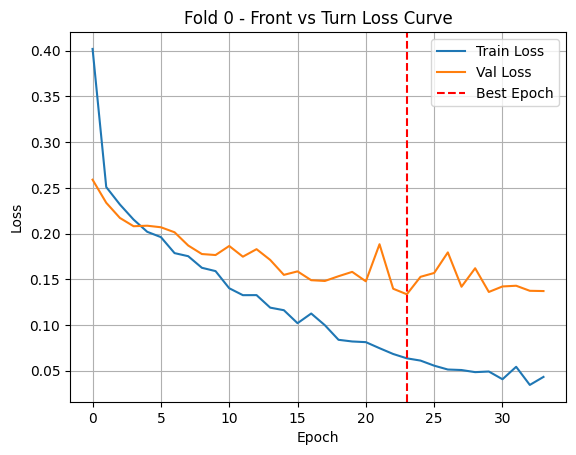

Confusion Matrix - Front vs Turn


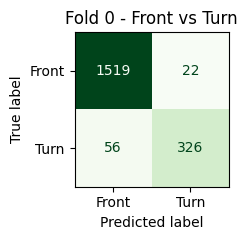

              precision    recall  f1-score   support

       Front     0.9644    0.9857    0.9750      1541
        Turn     0.9368    0.8534    0.8932       382

    accuracy                         0.9594      1923
   macro avg     0.9506    0.9196    0.9341      1923
weighted avg     0.9589    0.9594    0.9587      1923

Fold 0 - Left vs Right | Epoch 000 | Train: 0.5700 | Val: 0.3725
Fold 0 - Left vs Right | Epoch 001 | Train: 0.2824 | Val: 0.1896
Fold 0 - Left vs Right | Epoch 002 | Train: 0.2189 | Val: 0.1721
Fold 0 - Left vs Right | Epoch 003 | Train: 0.2081 | Val: 0.1722
Fold 0 - Left vs Right | Epoch 004 | Train: 0.1602 | Val: 0.1511
Fold 0 - Left vs Right | Epoch 005 | Train: 0.1469 | Val: 0.1287
Fold 0 - Left vs Right | Epoch 006 | Train: 0.1212 | Val: 0.1256
Fold 0 - Left vs Right | Epoch 007 | Train: 0.1182 | Val: 0.1200
Fold 0 - Left vs Right | Epoch 008 | Train: 0.1220 | Val: 0.1026
Fold 0 - Left vs Right | Epoch 009 | Train: 0.0850 | Val: 0.0915
Fold 0 - Left vs Right 

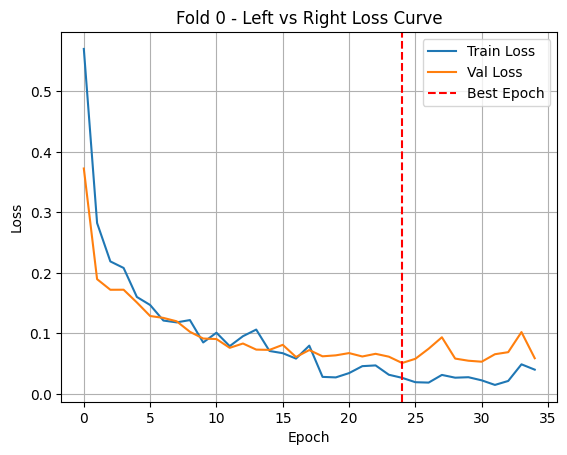

Confusion Matrix - Left vs Right


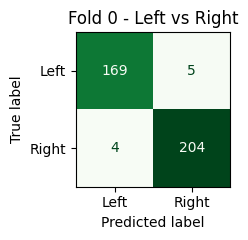

              precision    recall  f1-score   support

        Left     0.9769    0.9713    0.9741       174
       Right     0.9761    0.9808    0.9784       208

    accuracy                         0.9764       382
   macro avg     0.9765    0.9760    0.9762       382
weighted avg     0.9764    0.9764    0.9764       382



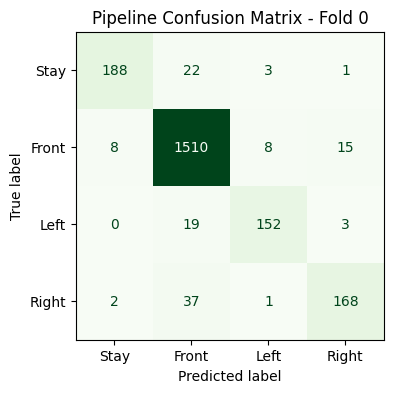

Fold 0 - Classification Report (Pipeline)
              precision    recall  f1-score   support

        Stay     0.9495    0.8785    0.9126       214
       Front     0.9509    0.9799    0.9652      1541
        Left     0.9268    0.8736    0.8994       174
       Right     0.8984    0.8077    0.8506       208

    accuracy                         0.9443      2137
   macro avg     0.9314    0.8849    0.9070      2137
weighted avg     0.9437    0.9443    0.9434      2137


=== Fold 1 ===
Fold 1 - Stay vs Move | Epoch 000 | Train: 0.2891 | Val: 0.1795
Fold 1 - Stay vs Move | Epoch 001 | Train: 0.1435 | Val: 0.1444
Fold 1 - Stay vs Move | Epoch 002 | Train: 0.1183 | Val: 0.1231
Fold 1 - Stay vs Move | Epoch 003 | Train: 0.1046 | Val: 0.1041
Fold 1 - Stay vs Move | Epoch 004 | Train: 0.0927 | Val: 0.1108
Fold 1 - Stay vs Move | Epoch 005 | Train: 0.0860 | Val: 0.0943
Fold 1 - Stay vs Move | Epoch 006 | Train: 0.0785 | Val: 0.0818
Fold 1 - Stay vs Move | Epoch 007 | Train: 0.0762 | Val: 0.

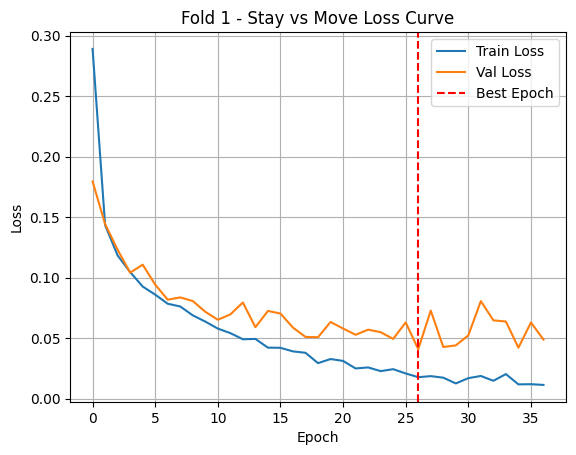

Confusion Matrix - Stay vs Move


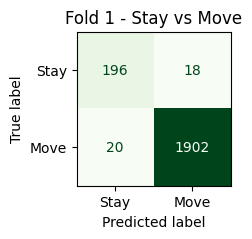

              precision    recall  f1-score   support

        Stay     0.9074    0.9159    0.9116       214
        Move     0.9906    0.9896    0.9901      1922

    accuracy                         0.9822      2136
   macro avg     0.9490    0.9527    0.9509      2136
weighted avg     0.9823    0.9822    0.9822      2136

Fold 1 - Front vs Turn | Epoch 000 | Train: 0.3994 | Val: 0.2666
Fold 1 - Front vs Turn | Epoch 001 | Train: 0.2550 | Val: 0.2515
Fold 1 - Front vs Turn | Epoch 002 | Train: 0.2296 | Val: 0.2384
Fold 1 - Front vs Turn | Epoch 003 | Train: 0.2190 | Val: 0.2389
Fold 1 - Front vs Turn | Epoch 004 | Train: 0.2093 | Val: 0.2234
Fold 1 - Front vs Turn | Epoch 005 | Train: 0.1963 | Val: 0.2196
Fold 1 - Front vs Turn | Epoch 006 | Train: 0.1907 | Val: 0.2210
Fold 1 - Front vs Turn | Epoch 007 | Train: 0.1785 | Val: 0.1938
Fold 1 - Front vs Turn | Epoch 008 | Train: 0.1632 | Val: 0.2021
Fold 1 - Front vs Turn | Epoch 009 | Train: 0.1647 | Val: 0.1930
Fold 1 - Front vs Turn 

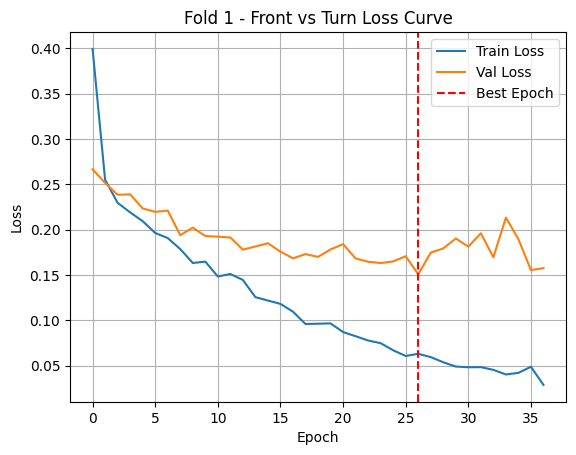

Confusion Matrix - Front vs Turn


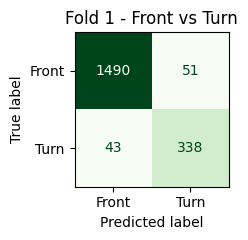

              precision    recall  f1-score   support

       Front     0.9720    0.9669    0.9694      1541
        Turn     0.8689    0.8871    0.8779       381

    accuracy                         0.9511      1922
   macro avg     0.9204    0.9270    0.9237      1922
weighted avg     0.9515    0.9511    0.9513      1922

Fold 1 - Left vs Right | Epoch 000 | Train: 0.5551 | Val: 0.3971
Fold 1 - Left vs Right | Epoch 001 | Train: 0.2650 | Val: 0.2357
Fold 1 - Left vs Right | Epoch 002 | Train: 0.1957 | Val: 0.1908
Fold 1 - Left vs Right | Epoch 003 | Train: 0.1522 | Val: 0.1641
Fold 1 - Left vs Right | Epoch 004 | Train: 0.1459 | Val: 0.1822
Fold 1 - Left vs Right | Epoch 005 | Train: 0.1485 | Val: 0.1397
Fold 1 - Left vs Right | Epoch 006 | Train: 0.1202 | Val: 0.1186
Fold 1 - Left vs Right | Epoch 007 | Train: 0.1242 | Val: 0.1307
Fold 1 - Left vs Right | Epoch 008 | Train: 0.1349 | Val: 0.1166
Fold 1 - Left vs Right | Epoch 009 | Train: 0.0960 | Val: 0.1156
Fold 1 - Left vs Right 

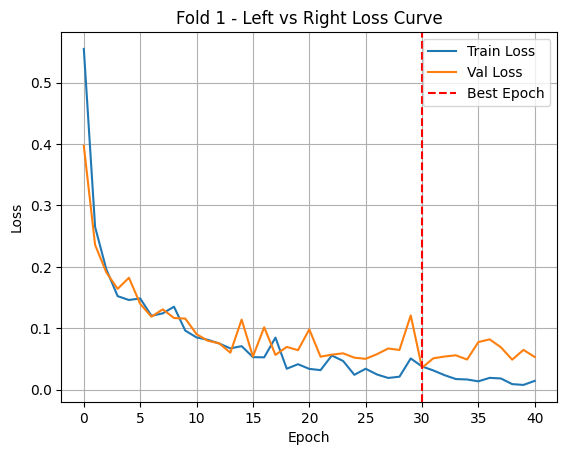

Confusion Matrix - Left vs Right


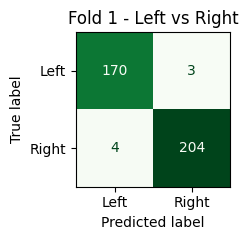

              precision    recall  f1-score   support

        Left     0.9770    0.9827    0.9798       173
       Right     0.9855    0.9808    0.9831       208

    accuracy                         0.9816       381
   macro avg     0.9813    0.9817    0.9815       381
weighted avg     0.9816    0.9816    0.9816       381



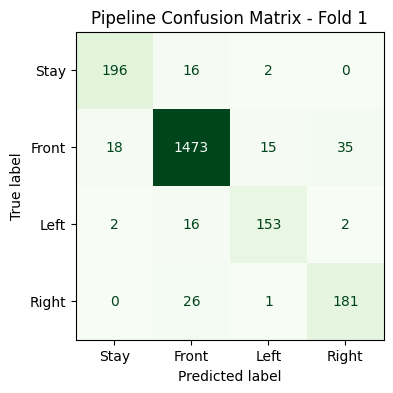

Fold 1 - Classification Report (Pipeline)
              precision    recall  f1-score   support

        Stay     0.9074    0.9159    0.9116       214
       Front     0.9621    0.9559    0.9590      1541
        Left     0.8947    0.8844    0.8895       173
       Right     0.8303    0.8702    0.8498       208

    accuracy                         0.9377      2136
   macro avg     0.8986    0.9066    0.9025      2136
weighted avg     0.9383    0.9377    0.9380      2136


=== Fold 2 ===
Fold 2 - Stay vs Move | Epoch 000 | Train: 0.2820 | Val: 0.1653
Fold 2 - Stay vs Move | Epoch 001 | Train: 0.1387 | Val: 0.1127
Fold 2 - Stay vs Move | Epoch 002 | Train: 0.1114 | Val: 0.1082
Fold 2 - Stay vs Move | Epoch 003 | Train: 0.1024 | Val: 0.1042
Fold 2 - Stay vs Move | Epoch 004 | Train: 0.0913 | Val: 0.1064
Fold 2 - Stay vs Move | Epoch 005 | Train: 0.0911 | Val: 0.0986
Fold 2 - Stay vs Move | Epoch 006 | Train: 0.0831 | Val: 0.0827
Fold 2 - Stay vs Move | Epoch 007 | Train: 0.0765 | Val: 0.

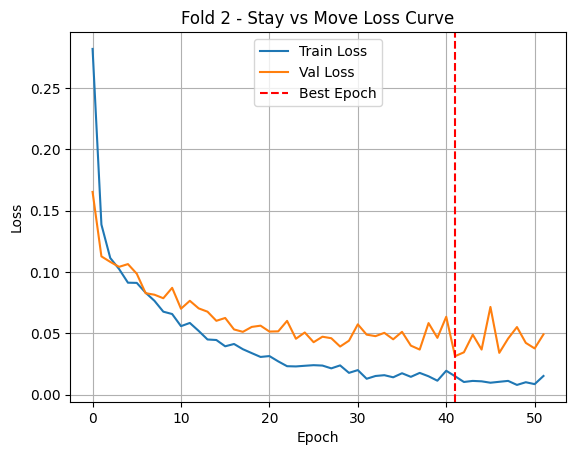

Confusion Matrix - Stay vs Move


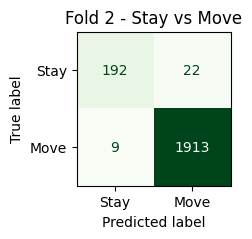

              precision    recall  f1-score   support

        Stay     0.9552    0.8972    0.9253       214
        Move     0.9886    0.9953    0.9920      1922

    accuracy                         0.9855      2136
   macro avg     0.9719    0.9463    0.9586      2136
weighted avg     0.9853    0.9855    0.9853      2136

Fold 2 - Front vs Turn | Epoch 000 | Train: 0.4076 | Val: 0.2624
Fold 2 - Front vs Turn | Epoch 001 | Train: 0.2618 | Val: 0.2352
Fold 2 - Front vs Turn | Epoch 002 | Train: 0.2343 | Val: 0.2193
Fold 2 - Front vs Turn | Epoch 003 | Train: 0.2216 | Val: 0.2152
Fold 2 - Front vs Turn | Epoch 004 | Train: 0.2064 | Val: 0.1952
Fold 2 - Front vs Turn | Epoch 005 | Train: 0.1981 | Val: 0.1880
Fold 2 - Front vs Turn | Epoch 006 | Train: 0.1850 | Val: 0.1893
Fold 2 - Front vs Turn | Epoch 007 | Train: 0.1718 | Val: 0.2017
Fold 2 - Front vs Turn | Epoch 008 | Train: 0.1688 | Val: 0.1771
Fold 2 - Front vs Turn | Epoch 009 | Train: 0.1633 | Val: 0.1850
Fold 2 - Front vs Turn 

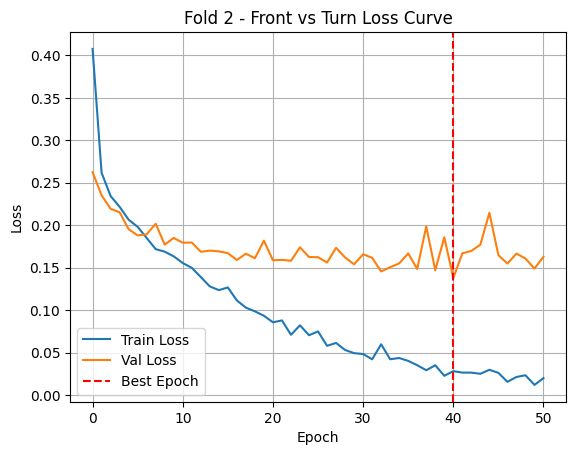

Confusion Matrix - Front vs Turn


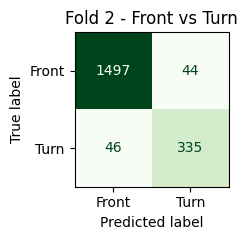

              precision    recall  f1-score   support

       Front     0.9702    0.9714    0.9708      1541
        Turn     0.8839    0.8793    0.8816       381

    accuracy                         0.9532      1922
   macro avg     0.9270    0.9254    0.9262      1922
weighted avg     0.9531    0.9532    0.9531      1922

Fold 2 - Left vs Right | Epoch 000 | Train: 0.5354 | Val: 0.3385
Fold 2 - Left vs Right | Epoch 001 | Train: 0.2627 | Val: 0.1811
Fold 2 - Left vs Right | Epoch 002 | Train: 0.1941 | Val: 0.1566
Fold 2 - Left vs Right | Epoch 003 | Train: 0.1747 | Val: 0.1339
Fold 2 - Left vs Right | Epoch 004 | Train: 0.1539 | Val: 0.1170
Fold 2 - Left vs Right | Epoch 005 | Train: 0.1402 | Val: 0.1018
Fold 2 - Left vs Right | Epoch 006 | Train: 0.1408 | Val: 0.0951
Fold 2 - Left vs Right | Epoch 007 | Train: 0.1231 | Val: 0.0924
Fold 2 - Left vs Right | Epoch 008 | Train: 0.1009 | Val: 0.0855
Fold 2 - Left vs Right | Epoch 009 | Train: 0.1183 | Val: 0.0940
Fold 2 - Left vs Right 

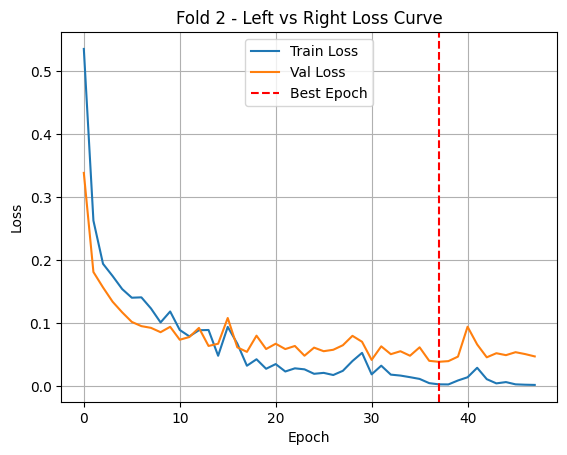

Confusion Matrix - Left vs Right


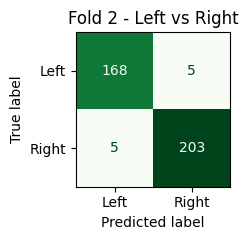

              precision    recall  f1-score   support

        Left     0.9711    0.9711    0.9711       173
       Right     0.9760    0.9760    0.9760       208

    accuracy                         0.9738       381
   macro avg     0.9735    0.9735    0.9735       381
weighted avg     0.9738    0.9738    0.9738       381



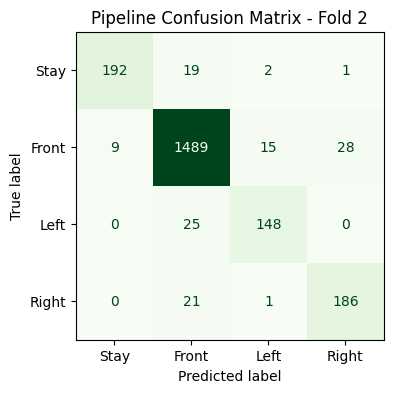

Fold 2 - Classification Report (Pipeline)
              precision    recall  f1-score   support

        Stay     0.9552    0.8972    0.9253       214
       Front     0.9582    0.9663    0.9622      1541
        Left     0.8916    0.8555    0.8732       173
       Right     0.8651    0.8942    0.8794       208

    accuracy                         0.9434      2136
   macro avg     0.9175    0.9033    0.9100      2136
weighted avg     0.9434    0.9434    0.9432      2136


=== Fold 3 ===
Fold 3 - Stay vs Move | Epoch 000 | Train: 0.2797 | Val: 0.1531
Fold 3 - Stay vs Move | Epoch 001 | Train: 0.1344 | Val: 0.1152
Fold 3 - Stay vs Move | Epoch 002 | Train: 0.1150 | Val: 0.1086
Fold 3 - Stay vs Move | Epoch 003 | Train: 0.1016 | Val: 0.1004
Fold 3 - Stay vs Move | Epoch 004 | Train: 0.0960 | Val: 0.1026
Fold 3 - Stay vs Move | Epoch 005 | Train: 0.0887 | Val: 0.0902
Fold 3 - Stay vs Move | Epoch 006 | Train: 0.0785 | Val: 0.0891
Fold 3 - Stay vs Move | Epoch 007 | Train: 0.0673 | Val: 0.

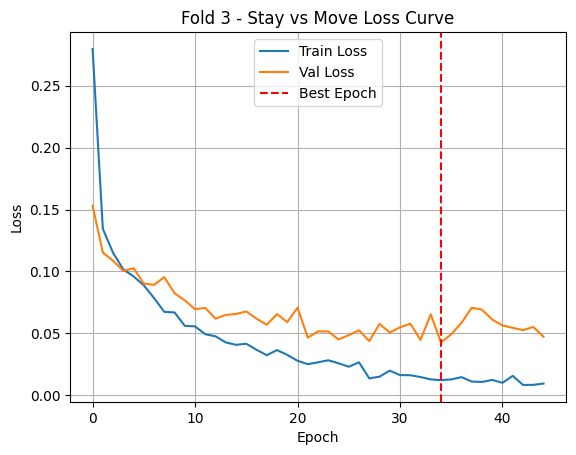

Confusion Matrix - Stay vs Move


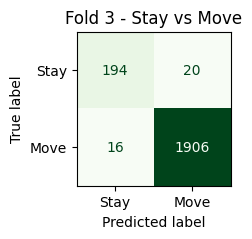

              precision    recall  f1-score   support

        Stay     0.9238    0.9065    0.9151       214
        Move     0.9896    0.9917    0.9906      1922

    accuracy                         0.9831      2136
   macro avg     0.9567    0.9491    0.9529      2136
weighted avg     0.9830    0.9831    0.9831      2136

Fold 3 - Front vs Turn | Epoch 000 | Train: 0.4063 | Val: 0.2413
Fold 3 - Front vs Turn | Epoch 001 | Train: 0.2546 | Val: 0.2188
Fold 3 - Front vs Turn | Epoch 002 | Train: 0.2351 | Val: 0.2085
Fold 3 - Front vs Turn | Epoch 003 | Train: 0.2244 | Val: 0.2084
Fold 3 - Front vs Turn | Epoch 004 | Train: 0.2068 | Val: 0.1907
Fold 3 - Front vs Turn | Epoch 005 | Train: 0.1929 | Val: 0.1777
Fold 3 - Front vs Turn | Epoch 006 | Train: 0.1829 | Val: 0.1792
Fold 3 - Front vs Turn | Epoch 007 | Train: 0.1707 | Val: 0.1691
Fold 3 - Front vs Turn | Epoch 008 | Train: 0.1598 | Val: 0.1651
Fold 3 - Front vs Turn | Epoch 009 | Train: 0.1544 | Val: 0.1569
Fold 3 - Front vs Turn 

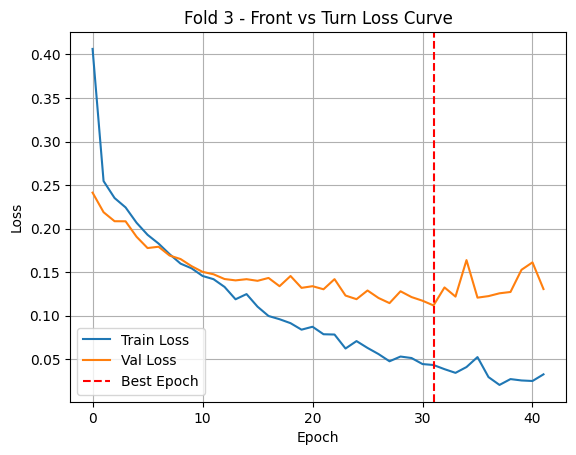

Confusion Matrix - Front vs Turn


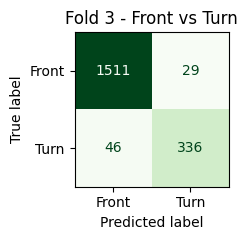

              precision    recall  f1-score   support

       Front     0.9705    0.9812    0.9758      1540
        Turn     0.9205    0.8796    0.8996       382

    accuracy                         0.9610      1922
   macro avg     0.9455    0.9304    0.9377      1922
weighted avg     0.9605    0.9610    0.9606      1922

Fold 3 - Left vs Right | Epoch 000 | Train: 0.5544 | Val: 0.3692
Fold 3 - Left vs Right | Epoch 001 | Train: 0.2793 | Val: 0.1963
Fold 3 - Left vs Right | Epoch 002 | Train: 0.2146 | Val: 0.1692
Fold 3 - Left vs Right | Epoch 003 | Train: 0.1731 | Val: 0.1418
Fold 3 - Left vs Right | Epoch 004 | Train: 0.1604 | Val: 0.1409
Fold 3 - Left vs Right | Epoch 005 | Train: 0.1400 | Val: 0.1097
Fold 3 - Left vs Right | Epoch 006 | Train: 0.1165 | Val: 0.1043
Fold 3 - Left vs Right | Epoch 007 | Train: 0.0980 | Val: 0.0954
Fold 3 - Left vs Right | Epoch 008 | Train: 0.0841 | Val: 0.0926
Fold 3 - Left vs Right | Epoch 009 | Train: 0.0927 | Val: 0.1224
Fold 3 - Left vs Right 

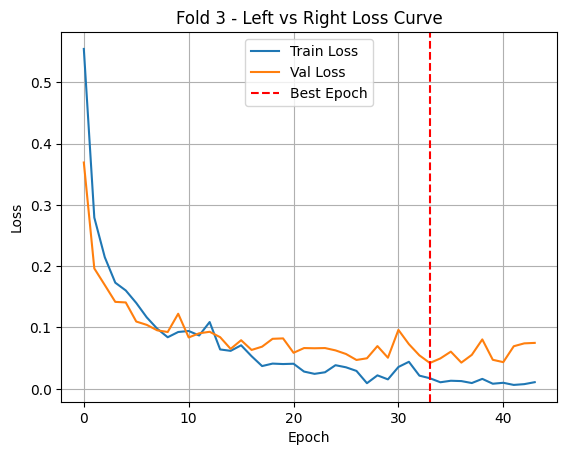

Confusion Matrix - Left vs Right


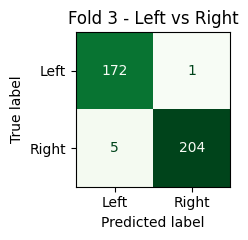

              precision    recall  f1-score   support

        Left     0.9718    0.9942    0.9829       173
       Right     0.9951    0.9761    0.9855       209

    accuracy                         0.9843       382
   macro avg     0.9834    0.9851    0.9842       382
weighted avg     0.9845    0.9843    0.9843       382



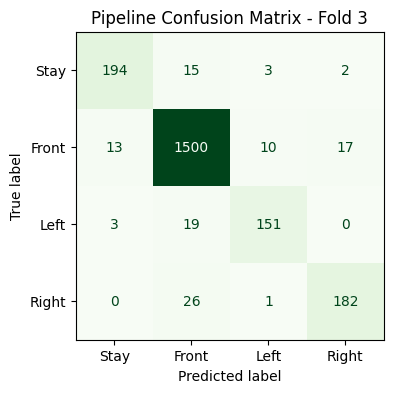

Fold 3 - Classification Report (Pipeline)
              precision    recall  f1-score   support

        Stay     0.9238    0.9065    0.9151       214
       Front     0.9615    0.9740    0.9677      1540
        Left     0.9152    0.8728    0.8935       173
       Right     0.9055    0.8708    0.8878       209

    accuracy                         0.9490      2136
   macro avg     0.9265    0.9061    0.9160      2136
weighted avg     0.9485    0.9490    0.9486      2136


=== Fold 4 ===
Fold 4 - Stay vs Move | Epoch 000 | Train: 0.2986 | Val: 0.1678
Fold 4 - Stay vs Move | Epoch 001 | Train: 0.1365 | Val: 0.1196
Fold 4 - Stay vs Move | Epoch 002 | Train: 0.1104 | Val: 0.1141
Fold 4 - Stay vs Move | Epoch 003 | Train: 0.0989 | Val: 0.1056
Fold 4 - Stay vs Move | Epoch 004 | Train: 0.0890 | Val: 0.1090
Fold 4 - Stay vs Move | Epoch 005 | Train: 0.0850 | Val: 0.1049
Fold 4 - Stay vs Move | Epoch 006 | Train: 0.0795 | Val: 0.0895
Fold 4 - Stay vs Move | Epoch 007 | Train: 0.0688 | Val: 0.

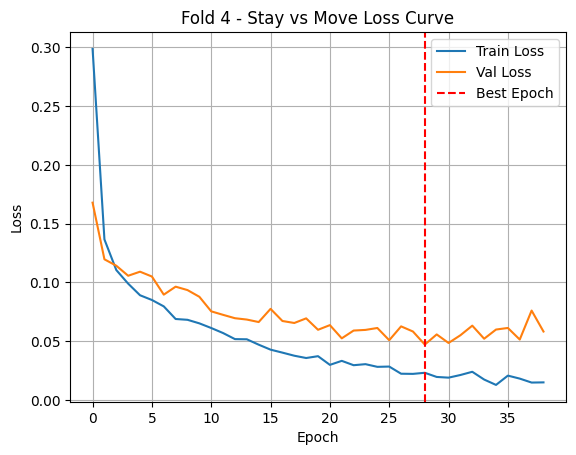

Confusion Matrix - Stay vs Move


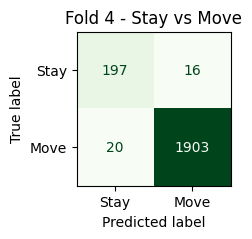

              precision    recall  f1-score   support

        Stay     0.9078    0.9249    0.9163       213
        Move     0.9917    0.9896    0.9906      1923

    accuracy                         0.9831      2136
   macro avg     0.9497    0.9572    0.9535      2136
weighted avg     0.9833    0.9831    0.9832      2136

Fold 4 - Front vs Turn | Epoch 000 | Train: 0.3856 | Val: 0.2747
Fold 4 - Front vs Turn | Epoch 001 | Train: 0.2499 | Val: 0.2663
Fold 4 - Front vs Turn | Epoch 002 | Train: 0.2283 | Val: 0.2473
Fold 4 - Front vs Turn | Epoch 003 | Train: 0.2192 | Val: 0.2422
Fold 4 - Front vs Turn | Epoch 004 | Train: 0.2079 | Val: 0.2334
Fold 4 - Front vs Turn | Epoch 005 | Train: 0.1937 | Val: 0.2252
Fold 4 - Front vs Turn | Epoch 006 | Train: 0.1857 | Val: 0.2214
Fold 4 - Front vs Turn | Epoch 007 | Train: 0.1779 | Val: 0.2253
Fold 4 - Front vs Turn | Epoch 008 | Train: 0.1729 | Val: 0.2068
Fold 4 - Front vs Turn | Epoch 009 | Train: 0.1621 | Val: 0.2046
Fold 4 - Front vs Turn 

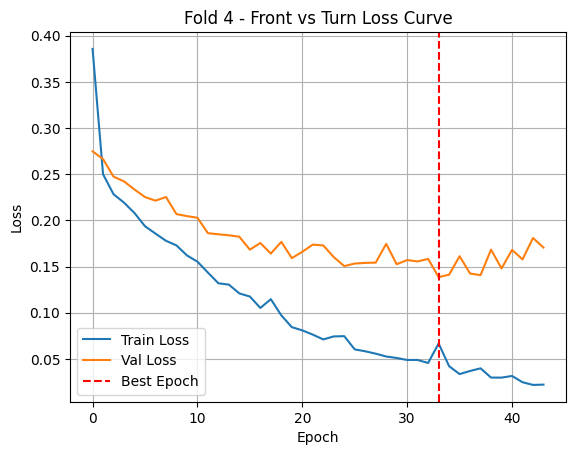

Confusion Matrix - Front vs Turn


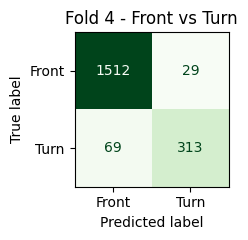

              precision    recall  f1-score   support

       Front     0.9564    0.9812    0.9686      1541
        Turn     0.9152    0.8194    0.8646       382

    accuracy                         0.9490      1923
   macro avg     0.9358    0.9003    0.9166      1923
weighted avg     0.9482    0.9490    0.9480      1923

Fold 4 - Left vs Right | Epoch 000 | Train: 0.5633 | Val: 0.4149
Fold 4 - Left vs Right | Epoch 001 | Train: 0.2766 | Val: 0.2234
Fold 4 - Left vs Right | Epoch 002 | Train: 0.1924 | Val: 0.1939
Fold 4 - Left vs Right | Epoch 003 | Train: 0.1569 | Val: 0.1700
Fold 4 - Left vs Right | Epoch 004 | Train: 0.1427 | Val: 0.1656
Fold 4 - Left vs Right | Epoch 005 | Train: 0.1199 | Val: 0.1482
Fold 4 - Left vs Right | Epoch 006 | Train: 0.1123 | Val: 0.1573
Fold 4 - Left vs Right | Epoch 007 | Train: 0.1007 | Val: 0.1365
Fold 4 - Left vs Right | Epoch 008 | Train: 0.0878 | Val: 0.1333
Fold 4 - Left vs Right | Epoch 009 | Train: 0.1005 | Val: 0.1428
Fold 4 - Left vs Right 

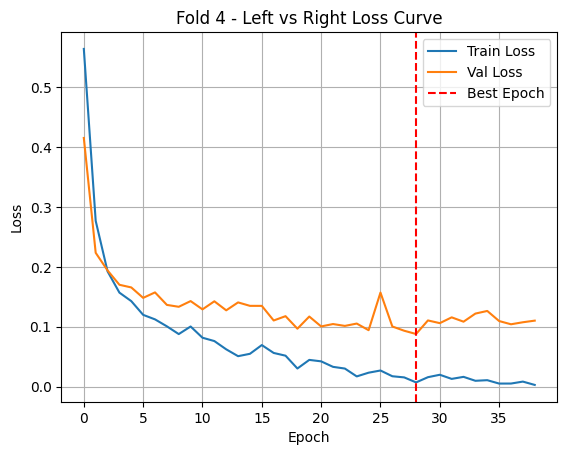

Confusion Matrix - Left vs Right


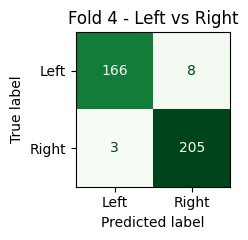

              precision    recall  f1-score   support

        Left     0.9822    0.9540    0.9679       174
       Right     0.9624    0.9856    0.9739       208

    accuracy                         0.9712       382
   macro avg     0.9723    0.9698    0.9709       382
weighted avg     0.9715    0.9712    0.9712       382



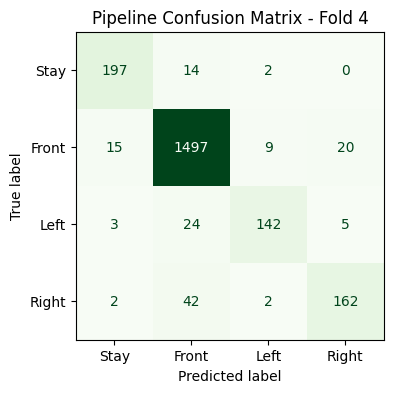

Fold 4 - Classification Report (Pipeline)
              precision    recall  f1-score   support

        Stay     0.9078    0.9249    0.9163       213
       Front     0.9493    0.9714    0.9602      1541
        Left     0.9161    0.8161    0.8632       174
       Right     0.8663    0.7788    0.8203       208

    accuracy                         0.9354      2136
   macro avg     0.9099    0.8728    0.8900      2136
weighted avg     0.9344    0.9354    0.9343      2136



In [9]:
for fold_idx, (train_idx, test_idx) in enumerate(folds):
    print(f"\n=== Fold {fold_idx} ===")

    X_train_raw, y_train_raw = X_all[train_idx], y_all[train_idx]
    X_test_raw, y_test_raw = X_all[test_idx], y_all[test_idx]

    # STEP 1: Stay vs Move
    y_train_stay = np.array([0 if y == 'Stay' else 1 for y in y_train_raw])
    y_test_stay = np.array([0 if y == 'Stay' else 1 for y in y_test_raw])

    model_stay = train_binary_model(
        X_train_raw, y_train_stay,
        X_test_raw, y_test_stay,
        feature_dim=X_train_raw.shape[2],
        label_name=f"Fold {fold_idx} - Stay vs Move"
    )

    preds_stay = model_stay(torch.tensor(X_test_raw, dtype=torch.float32).to(device)).argmax(dim=1).cpu().numpy()
    print("Confusion Matrix - Stay vs Move")
    cm_stay = confusion_matrix(y_test_stay, preds_stay)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    disp = ConfusionMatrixDisplay(cm_stay, display_labels=["Stay", "Move"])
    disp.plot(ax=ax, cmap='Greens', values_format='d', colorbar=False)
    plt.title(f"Fold {fold_idx} - Stay vs Move")
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y_test_stay, preds_stay, target_names=["Stay", "Move"], digits=4))


    # STEP 2: Front vs Turn
    move_idx_train = np.where(y_train_stay == 1)[0]
    move_idx_test = np.where(y_test_stay == 1)[0]

    X_train_straight = X_train_raw[move_idx_train]
    y_train_straight = np.array([0 if y == 'Front' else 1 for y in y_train_raw[move_idx_train]])

    X_test_straight = X_test_raw[move_idx_test]
    y_test_straight = np.array([0 if y == 'Front' else 1 for y in y_test_raw[move_idx_test]])

    model_straight = train_binary_model(
        X_train_straight, y_train_straight,
        X_test_straight, y_test_straight,
        feature_dim=X_train_raw.shape[2],
        label_name=f"Fold {fold_idx} - Front vs Turn"
    )

    preds_straight = model_straight(torch.tensor(X_test_straight, dtype=torch.float32).to(device)).argmax(dim=1).cpu().numpy()
    print("Confusion Matrix - Front vs Turn")
    cm_straight = confusion_matrix(y_test_straight, preds_straight)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    disp = ConfusionMatrixDisplay(cm_straight, display_labels=["Front", "Turn"])
    disp.plot(ax=ax, cmap='Greens', values_format='d', colorbar=False)
    plt.title(f"Fold {fold_idx} - Front vs Turn")
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y_test_straight, preds_straight, target_names=["Front", "Turn"], digits=4))


    # STEP 3: Left vs Right
    turn_idx_train = move_idx_train[np.where(y_train_straight == 1)[0]]
    turn_idx_test = move_idx_test[np.where(y_test_straight == 1)[0]]

    X_train_turn = X_train_raw[turn_idx_train]
    y_train_turn = np.array([0 if y == 'Left' else 1 for y in y_train_raw[turn_idx_train]])

    X_test_turn = X_test_raw[turn_idx_test]
    y_test_turn = np.array([0 if y == 'Left' else 1 for y in y_test_raw[turn_idx_test]])

    model_turn = train_binary_model(
        X_train_turn, y_train_turn,
        X_test_turn, y_test_turn,
        feature_dim=X_train_raw.shape[2],
        label_name=f"Fold {fold_idx} - Left vs Right"
    )

    preds_turn = model_turn(torch.tensor(X_test_turn, dtype=torch.float32).to(device)).argmax(dim=1).cpu().numpy()
    print("Confusion Matrix - Left vs Right")
    cm_turn = confusion_matrix(y_test_turn, preds_turn)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    disp = ConfusionMatrixDisplay(cm_turn, display_labels=["Left", "Right"])
    disp.plot(ax=ax, cmap='Greens', values_format='d', colorbar=False)
    plt.title(f"Fold {fold_idx} - Left vs Right")
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y_test_turn, preds_turn, target_names=["Left", "Right"], digits=4))


    # ✅ 최종 파이프라인 예측
    model_stay.eval()
    model_straight.eval()
    model_turn.eval()
    y_pred_final = []

    with torch.no_grad():
        for x in torch.tensor(X_test_raw, dtype=torch.float32).to(device):
            x = x.unsqueeze(0)
            pred1 = model_stay(x).argmax(dim=1).item()
            if pred1 == 0:
                y_pred_final.append('Stay')
            else:
                pred2 = model_straight(x).argmax(dim=1).item()
                if pred2 == 0:
                    y_pred_final.append('Front')
                else:
                    pred3 = model_turn(x).argmax(dim=1).item()
                    y_pred_final.append('Left' if pred3 == 0 else 'Right')

    # ✅ fold별 파이프라인 결과 분석
    cm = confusion_matrix(y_test_raw, y_pred_final, labels=all_labels)
    total_cm += cm
    total_y_true.extend(y_test_raw)
    total_y_pred.extend(y_pred_final)

    fig, ax = plt.subplots(figsize=(4,4))
    disp = ConfusionMatrixDisplay(cm, display_labels=all_labels)
    disp.plot(ax=ax, cmap='Greens', values_format='d', colorbar=False)
    plt.title(f'Pipeline Confusion Matrix - Fold {fold_idx}')
    plt.show()

    print(f"Fold {fold_idx} - Classification Report (Pipeline)")
    print(classification_report(y_test_raw, y_pred_final, labels=all_labels, target_names=all_labels, digits=4))



=== Total Confusion Matrix (All Folds) ===


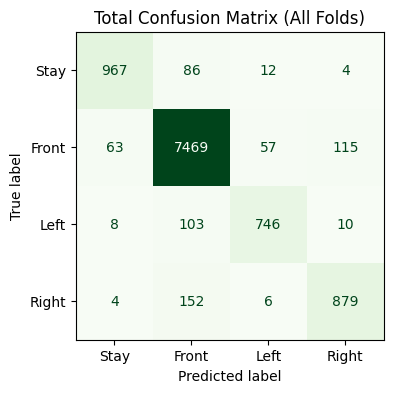


=== Total Classification Report (All Folds) ===
              precision    recall  f1-score   support

        Stay     0.9280    0.9046    0.9162      1069
       Front     0.9563    0.9695    0.9629      7704
        Left     0.9086    0.8604    0.8839       867
       Right     0.8720    0.8444    0.8580      1041

    accuracy                         0.9420     10681
   macro avg     0.9163    0.8947    0.9052     10681
weighted avg     0.9414    0.9420    0.9416     10681



In [10]:
print("\n=== Total Confusion Matrix (All Folds) ===")
fig, ax = plt.subplots(figsize=(4,4))
disp = ConfusionMatrixDisplay(total_cm, display_labels=all_labels)
disp.plot(ax=ax, cmap='Greens', values_format='d', colorbar=False)
plt.title('Total Confusion Matrix (All Folds)')
plt.show()

print("\n=== Total Classification Report (All Folds) ===")
print(classification_report(total_y_true, total_y_pred, labels=all_labels, target_names=all_labels, digits=4))


In [11]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

import json
import os
from datetime import datetime
import torch

# 🔹 저장 디렉토리 생성
os.makedirs('saved_models', exist_ok=True)

# 🔹 타임스탬프 생성
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 🔹 StandardScaler 저장 (JSON)
scaler_dict = {
    'mean_': scaler.mean_.tolist(),
    'scale_': scaler.scale_.tolist(),
    'feature_names': feature_cols
}

json_path = f'saved_models/standard_scaler_{timestamp}.json'
with open(json_path, 'w') as f:
    json.dump(scaler_dict, f)
print(f"스케일러 저장 완료: {json_path}")

# 🔹 모델 저장 (.pth)
torch.save(model_stay.state_dict(),     f'saved_models/best_model_stay_{timestamp}.pth')
torch.save(model_straight.state_dict(), f'saved_models/best_model_straight_{timestamp}.pth')
torch.save(model_turn.state_dict(),     f'saved_models/best_model_turn_{timestamp}.pth')

print(f"모델 저장 완료 (타임스탬프: {timestamp})")


스케일러 저장 완료: saved_models/standard_scaler_20250810_194404.json
모델 저장 완료 (타임스탬프: 20250810_194404)
